In [1]:
import numpy as np
import pylab as plt
import scipy.stats as ss
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

warning in stationary: failed to import cython module: falling back to numpy


# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2$ (for example from previous experiments or from literature), but we will assume that the data was measured with noise, so $\sigma^2=\sigma^2_0 + \sigma^2_n$. We are first interested in the mean $\mu$ of the generative model and afterwards in the variance $\sigma^2$, so we fix one of the parameters while we infer the other.

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: \mathcal{N}(0.5, 0.1)$

In [2]:
mu_t = 0.5
sigma_t = 0.1
noise = 1e-6

D = np.random.normal(mu_t, sigma_t + noise, 10)

<IPython.core.display.Javascript object>


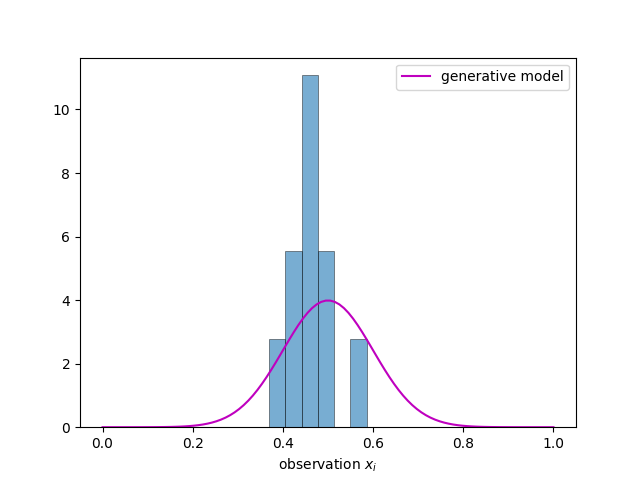

Text(0.5,0,'observation $x_i$')

In [3]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar", bins="auto")
x = np.linspace(0, 1, 100)
y = ss.norm.pdf(x, mu_t, sigma_t)
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = \prod_{i=1}^N \mathcal{N}(x_i|\mu, \sigma^2)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p_1(\theta) = Uniform(0, 1)$

$p_2(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0 = 1$

For the last prior, we switch our $\theta$ to become $\sigma^2$, that is we are now interested in the variance of our data and we assume that we now the mean $\mu$. 

$p_3(\theta=\lambda) = Gamma(2, 1/3)$ (loc=2)

<IPython.core.display.Javascript object>


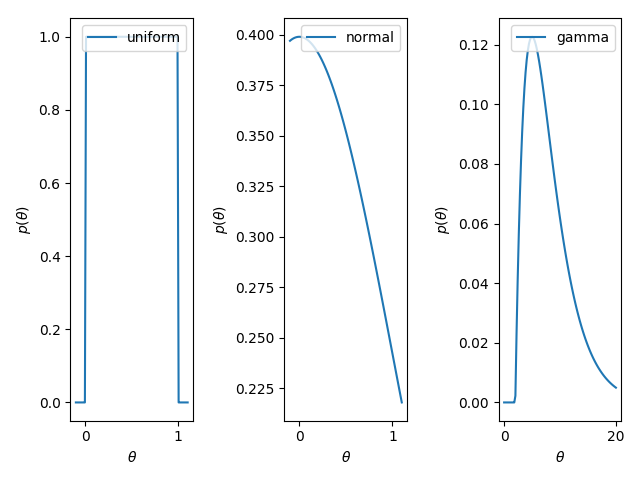

In [4]:
plt.figure()

# uniform prior
plt.subplot(1,3,1)
x = np.linspace(-0.1, 1.1, 100)
y = ss.uniform.pdf(x, 0, 1)
plt.plot(x,y, label="uniform")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# normal distributed prior
plt.subplot(1,3,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, 0, 1)
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# gamma distributed prior
plt.subplot(1,3,3)
x = np.linspace(0, 20, 100)
y = ss.gamma.pdf(x, a=2, scale=3, loc=2)
plt.plot(x,y, label="gamma")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.tight_layout()

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_1(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot 1 = \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \mu, \sigma^2_N = \cfrac{1}{N}\sigma^2 \\
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
p(\theta = \lambda = \frac{1}{\sigma^2}|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot Gamma(2, 2) = Gamma(a_N, b_N), a_N = a + \cfrac{N}{2}, b_N = b + \cfrac{1}{2}\sum_{i=1}^N (x_i - \mu)^2
\end{align}$

In [44]:
mu_t, sigma_t = 0.5, 0.1
mu_0, sigma_0 = 0, 1
a0, b0 = 2, 1/3
N = 10

posterior1 = lambda x,N: ss.norm.pdf(x, mu_t, 1/N * sigma_t)
posterior2 = lambda x,N: ss.norm.pdf(x, mu_t, 1 / (N * sigma_0 + sigma_t) * (sigma_t * mu_0 + N * sigma_0 * mu_t))
posterior3 = lambda x,N: ss.gamma.pdf(x, a=(a0 + N/2), scale = 1/(b0 + 0.5 * N * sigma_t))

<IPython.core.display.Javascript object>


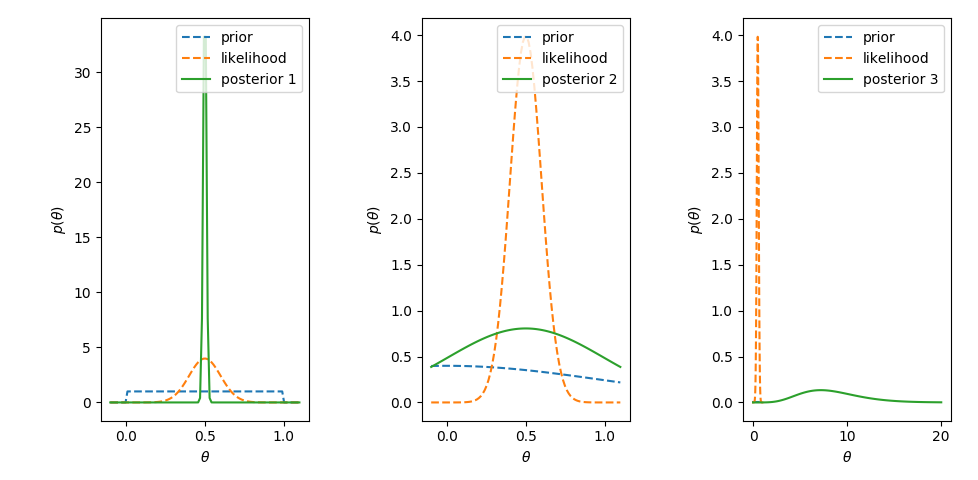

In [45]:
plt.figure()

# uniform prior
plt.subplot(1,3,1)
x = np.linspace(-0.1, 1.1, 100)
y = ss.uniform.pdf(x, 0, 1)
plt.plot(x,y, "--", label="prior")

x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_t, sigma_t)
plt.plot(x,y, "--", label="likelihood")

x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, N)
plt.plot(x,y, label="posterior 1")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.subplot(1,3,2)
# normal distributed prior
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, sigma_0)
plt.plot(x,y, "--", label="prior")

x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_t, sigma_t)
plt.plot(x,y, "--", label="likelihood")

x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, N)
plt.plot(x,y, label="posterior 2")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.subplot(1,3,3)
# gamma distributed prior
x = np.linspace(-0.1, 1.1, 100)
y = ss.gamma.pdf(x, a=a0, scale=1/b0, loc=2)
plt.plot(x,y, "--", label="prior")

x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_t, sigma_t)
plt.plot(x,y, "--", label="likelihood")

x = np.linspace(0, 20, 100)
y = posterior3(x, N)
plt.plot(x,y, label="posterior 3")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

plt.tight_layout()

# ABC

In [16]:
mu_t, sigma_t = 0.5, 0.1
mu_0, sigma_0 = 0, 1
a0, b0 = 2, 1/3
N = 10

prior1 = pyabc.Prior("uniform", 0, 1, name="mu")
prior2 = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name="mu")
prior3 = ss.gamma(a=a0, scale=1/b0, loc=2)
prior3.name = "lambda"

In [17]:
def simulator_mu(mu):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs(N)

def simulator_lambda(_lambda):
    return ss.norm(loc=mu_t, scale=np.sqrt(1/_lambda)).rvs(N)

In [18]:
def mean(x):
    return np.mean(x)

def var(x):
    return np.var(x)

<IPython.core.display.Javascript object>


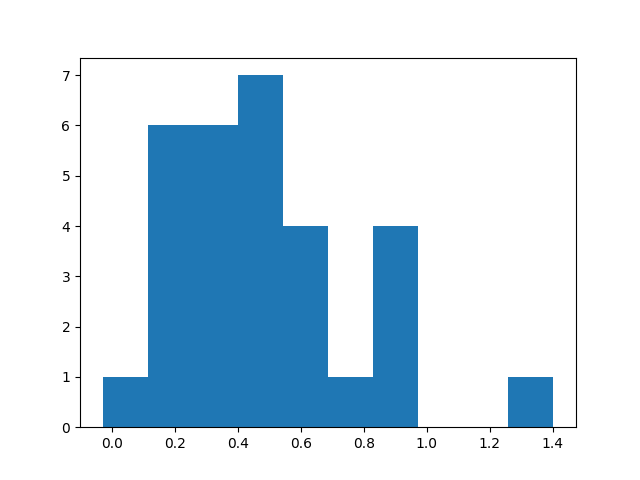

(array([ 1.,  6.,  6.,  7.,  4.,  1.,  4.,  0.,  0.,  1.]),
 array([-0.03128752,  0.11212082,  0.25552916,  0.3989375 ,  0.54234585,
         0.68575419,  0.82916253,  0.97257087,  1.11597921,  1.25938755,
         1.40279589]),
 <a list of 10 Patch objects>)

In [240]:
plt.figure()
plt.hist(simulator_mu(0.5))

<IPython.core.display.Javascript object>


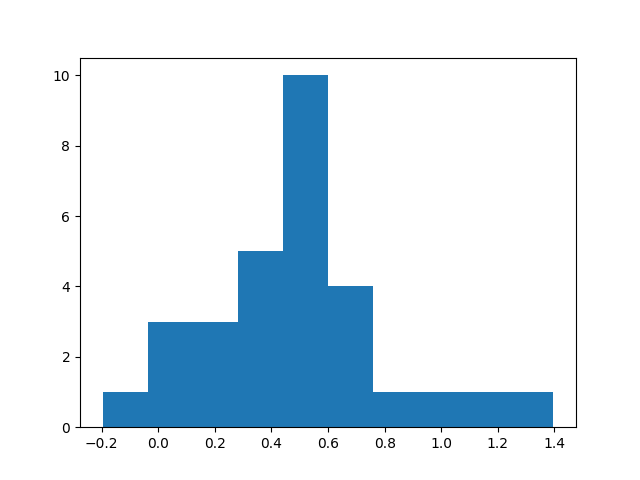

(array([  1.,   3.,   3.,   5.,  10.,   4.,   1.,   1.,   1.,   1.]),
 array([-0.1963382 , -0.0370718 ,  0.12219461,  0.28146101,  0.44072741,
         0.59999382,  0.75926022,  0.91852662,  1.07779303,  1.23705943,
         1.39632583]),
 <a list of 10 Patch objects>)

In [241]:
plt.figure()
plt.hist(simulator_lambda(10))

In [19]:
rej = pyabc.RejectionSampler(priors=prior1, simulator=simulator_mu, summaries=[mean, var], observation=D)

In [20]:
rej.sample(nr_samples=1000, threshold=0.1)

Rejection sampler started with threshold: 0.1 and number of samples: 1000
Samples:   1000 - Threshold: 0.1000 - Iterations:      11000 - Acceptance rate: 0.090909 - Time:     7.54 s


<IPython.core.display.Javascript object>


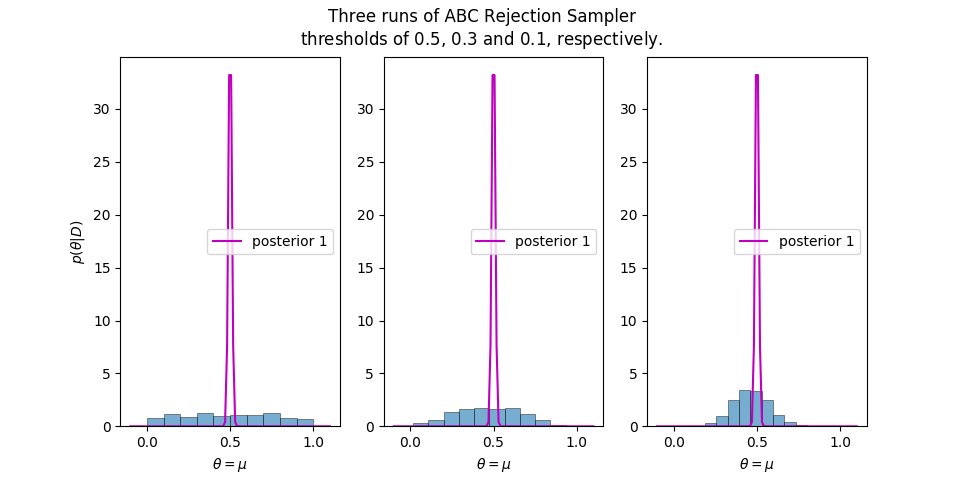

Rejection sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.5000 - Iterations:       2000 - Acceptance rate: 0.500000 - Time:     1.40 s
Rejection sampler started with threshold: 0.3 and number of samples: 1000
Samples:   1000 - Threshold: 0.3000 - Iterations:       2000 - Acceptance rate: 0.500000 - Time:     1.38 s
Rejection sampler started with threshold: 0.1 and number of samples: 1000
Samples:   1000 - Threshold: 0.1000 - Iterations:      11000 - Acceptance rate: 0.090909 - Time:     7.50 s


Text(0.5,0.98,'Three runs of ABC Rejection Sampler\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.')

In [41]:
fig = plt.figure()

rej.sample(nr_samples=1000, threshold=0.5)

plt.subplot(1,3,1)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")


rej.sample(nr_samples=1000, threshold=0.3)

plt.subplot(1,3,2)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")



rej.sample(nr_samples=1000, threshold=0.1)

plt.subplot(1,3,3)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior1(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")

fig.suptitle("Three runs of ABC Rejection Sampler for a uniform prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.")

In [46]:
rej = pyabc.RejectionSampler(priors=prior2, simulator=simulator_mu, summaries=[mean, var], observation=D)

In [ ]:
fig = plt.figure()

rej.sample(nr_samples=1000, threshold=0.5)

plt.subplot(1,3,1)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")
plt.ylabel(r"$p(\theta|D)$")


rej.sample(nr_samples=1000, threshold=0.3)

plt.subplot(1,3,2)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")



rej.sample(nr_samples=1000, threshold=0.1)

plt.subplot(1,3,3)
plt.hist(rej.Thetas, color="C0", alpha=0.6, edgecolor="k", linewidth=0.5, normed=True)
x = np.linspace(-0.1, 1.1, 100)
y = posterior2(x, 10)
plt.plot(x,y, "m-", label="posterior 1")
plt.legend(loc="upper right")

plt.xlabel(r"$\theta=\mu$")

fig.suptitle("Three runs of ABC Rejection Sampler for a normal prior\nthresholds of $0.5$, $0.3$ and $0.1$, respectively.")

<IPython.core.display.Javascript object>

Rejection sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.5000 - Iterations:       3000 - Acceptance rate: 0.333333 - Time:     2.11 s
Rejection sampler started with threshold: 0.3 and number of samples: 1000
Samples:   1000 - Threshold: 0.3000 - Iterations:       6000 - Acceptance rate: 0.166667 - Time:     3.93 s
Rejection sampler started with threshold: 0.1 and number of samples: 1000
